### Arsenii Gavrikov, ВШЭ + ОИЯИ
### gavrikov@jinr.ru

# Часть №5. BDT и нейросети

### Часть 1. BDT.

Подробнее и очень полезно: https://ml-handbook.ru/

Градиентный бустинг воплощает идею ансамблирования — обобщение предсказаний некоторого числа базовых алгоритмов в качестве итогового предсказания модели. Градиентный бустинг строится последовательно: каждый последующий алгоритм старается уменьшить ошибку текущего ансамбля. Причем, ансамблем называется множество базовых алгоритмов из одного семейства, которые объединяются затем в более сильную модель. Технически, в качестве базового алгоритма может выступать самые различные модели, например, линейные модели, но наиболее эффективным базовым алгоритмом градиентного бустинга является дерево решений.

BDT является прекрасным алгоритмом для работы с табличными данными и при правильном подходе может стать одним из лучших бейзлайнов.
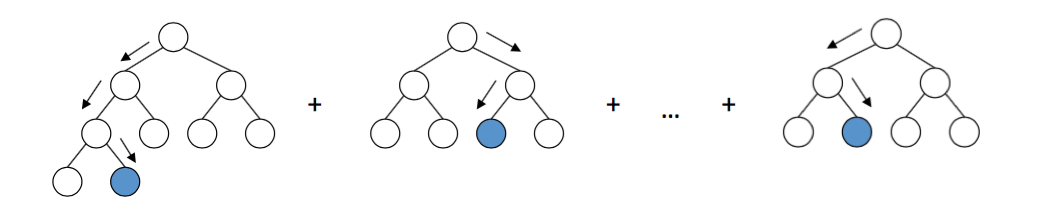

Одним из практических плюсов BDT является то, что, для получения базовой модели с неплохим качеством, можно использовать реализацию "из коробки", то есть не заниматься всесторонней оптимизацией гиперпараметров. Помимо этого, при оптимальном построении алгоритма BDT быстр в обучении и предсказании (BDT из sklearn медленный...).

Основные библиотеки для Python откуда можно достать BDT: 1) XGBoost, 2) CatBoost, 3) LightGBM

На практике сильной разницы нет, но имеются локальные преимущества каждой имлементации. В случае, когда не сильно хочется думать, можно брать самую популярную - XGBoost. 

Подробнее тут: https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc

In [1]:
# data: https://www.kaggle.com/code/mohitkarelia/predicting-invariant-mass-of-electron
import pandas as pd

df = pd.read_csv('data/dielectron.csv')
df.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


О данных

Контекст 

Датасет состоит из 100 тыс. диэлектронных событий с инвариантной массой от 2 до 110 ГэВ.

Описание столбцов:

1) Run: Номер рана (можно удалить, не несет информации о целевой переменной).

2) Event: Номер события (также можно удалить).

3, 11) E1, E2: Полная энергия электрона в ГэВ для первого и второго электронов соответственно.

4, 5, 6, 12, 13, 14) px1,py1,pz1,px2,py2,pz2: Координаты импульса для первого и второго 
электронов (ГэВ).

7, 15) pt1, pt2: поперечные импульсы электронов (ГэВ).

8, 16) eta1, eta2: псевдобыстрота электронов.

9, 17) phi1, phi2: Угол $\phi$ для электронов (радианы).

10, 18) Q1, Q2: Заряды электронов (1 - для антиэлектронов, -1 для электронов).

19) M: Инвариантная масса электронов (ГэВ).

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB


In [3]:
df = df.drop(columns=['Run', 'Event'])
df = df.dropna()

In [4]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22)

In [5]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_test_predict = xgb.predict(X_test)

In [6]:
RMSE = mean_squared_error(y_test, y_test_predict)**0.5
RMSE

3.9830794520061508

### Часть 2. Нейронные сети.

Свое название нейронные сети получили в связи с ранней работой [1], в которой У. Мак-Каллох и В. Питтс впервые пытались моделировать работу биологической нейронной сети в мозгу. Название крепко закрепилось
за математической (искусственной) нейронной сетью, несмотря на то, что их
реальное сходство с биологической нейронной сетью оказалось весьма условным.

Базовым объектом нейронной сети является математическая модель нейрона. Нейроны соединены между собой связями. Каждая связь имеет свой вес $\omega_i$. Каждый нейрон считает взвешенную сумму входных параметров и затем применяет к этому значению функцию активации: 
$$ g(\textbf{x}) = f\left(\sum_i{\omega_i x_i} + b\right), $$
где $b$ — смещенный вес, $x_i$ — входные значения, $f$ — функция активации, $g$ — выход нейрона.

Функция активации в нейроне должна быть нелинейной, иначе, в случае ее линейности, вся нейронная сеть просто будет сведена к линейной функции. В свою очередь, нелинейные функции активации позволяют аппроксимировать любую заданную функцию (когда размер сети сколько угодно большой).

Некоторые популярные нелинейные функции активации:
- 1) Сигмоида
- 2) ReLU (REctified Linear Unit)
- 3) Гиперболический тангенс

Пример работы нейрона изображен на рисунке слева. В полносвязной нейронной сети нейроны организованы в слои, где каждый нейрон в слое связан со всеми нейронами из предыдущего слоя. Пример полносвязной нейронной сети представлен на рисунке справа. Такую нейронную сеть можно разделить на три основные части: входной слой, скрытые слои, выходной слой. Входной слой получает признаки объекта. Выходной слой выдает результат предсказания модели — вероятность принадлежности к классу для задачи классификации, действительное число для задачи регрессии. Скрытые слои позволяют расширить пространство функций, которые нейронная сеть способна аппроксимировать.

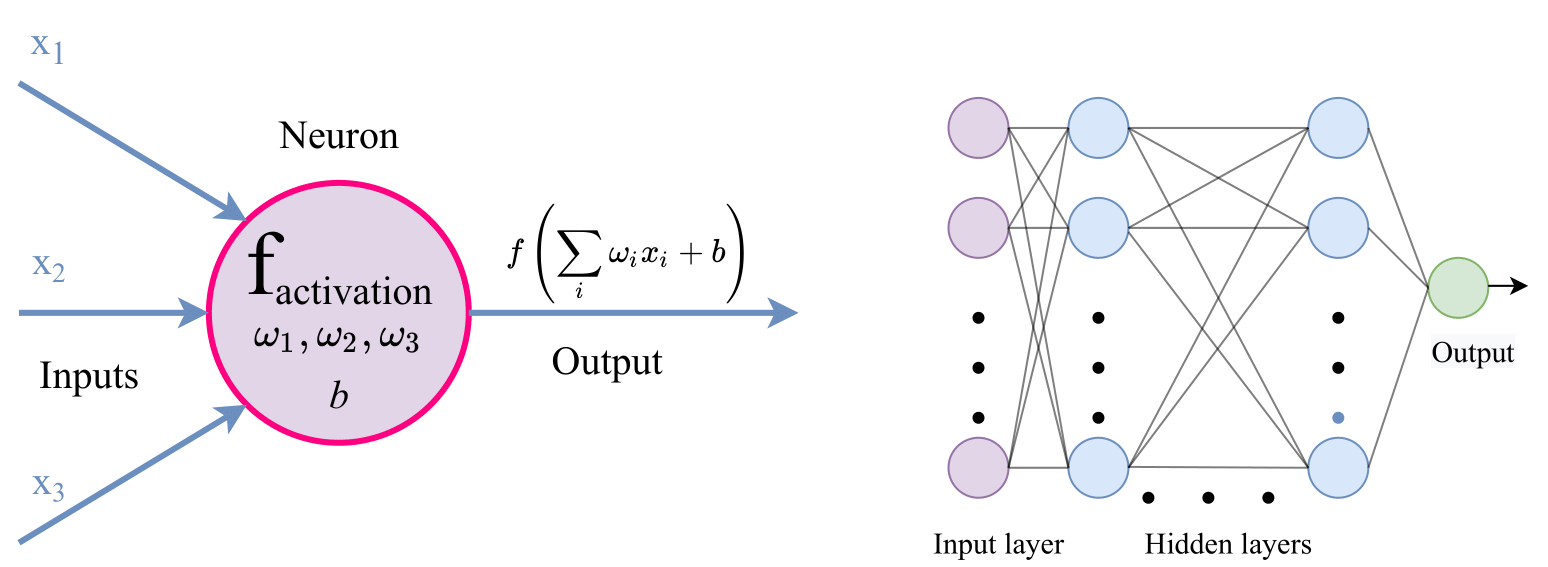.

[1] McCulloch W. S., Pitts W. A logical calculus of the ideas immanent in nervous activity // The bulletin of mathematical biophysics. – 1943. – Т. 5. – №. 4. – С. 115-133.

**Два основных фреймворка:**

- **Tensorflow-Keras** отличная библиотека для начала работы и обучения, интуитивная и подробная документация. Поддерживает обучение с CUDA.

- **PyTorch** на данный момент обошел по популярности Tensorflow. В перспективе освоить его будет крайне полезно. Лучше подходит для продвинутой работы (по моему мнению).

Более подробно: https://towardsdatascience.com/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b#:~:text=So%2C%20both%20TensorFlow%20and%20PyTorch,from%20which%20you%20may%20choose.

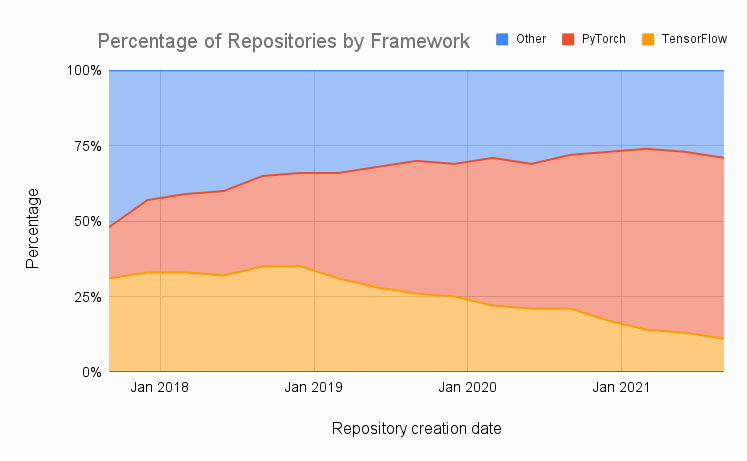

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
model = Sequential()

model.add(Dense(64, input_dim=16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, epochs=10, batch_size=256);

Epoch 1/10
313/313 [==============================] - 1s 1ms/step - loss: 505.6001 - mse: 505.6001
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 34.8946 - mse: 34.8946
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 20.2831 - mse: 20.2831
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 15.5268 - mse: 15.5268
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 12.5024 - mse: 12.5024
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 10.7279 - mse: 10.7279
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 9.5867 - mse: 9.5867
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 7.8708 - mse: 7.8708
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 7.6148 - mse: 7.6148
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 6.4267 - mse: 6.4267


In [9]:
y_test_predict = model.predict(X_test)
RMSE = mean_squared_error(y_test, y_test_predict)**0.5
RMSE

2.55924535291827

In [1]:
# !jupyter nbconvert Part5.ipynb --to slides --post serve --SlidesExporter.reveal_theme=serif  --SlidesExporter.reveal_scroll=True  --SlidesExporter.reveal_transition=none